# RISQ autograd

In this Notebook, we run Matteo's calculation in Python. We use the package autograd to build a computational graph that allows us to extract the Jacobian matrix of the computation, in this case $U(\theta_t, \theta_b, \theta_s)$ with other parameters fixed. $U$ is the $2\times 2$ unitary matrix representing the quantum gate.

Imports : 

This matches the script output. What if we sweep other angles : 

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np # Hack to get derivatives

In [2]:
%matplotlib inline

### From RISQ_MODEL.py

To reduce risk of mistake in tracer, I changed all non-np call (e.g. A.dot(B) ) to autograd calls (np.dot(A,B) ). Similarly, I made sure there was no in-place assignment. See https://github.com/HIPS/autograd/blob/master/docs/tutorial.md#supported-and-unsupported-parts-of-numpyscipy.

We focus on the RISQ gate for a specific set of parameters, and loop outside that function to see the behaviour across various values.

In [3]:
# Adapted Matteo Code
def generate_S_DB(theta_b, theta_t, eta_sqrd, tau_sqrd):
    eta = np.sqrt(eta_sqrd)
    tau = np.sqrt(tau_sqrd)
    kappa = 1j * np.sqrt(1. - tau_sqrd)
    gamma = 1j * np.sqrt(1. - eta_sqrd)

    T_b = generate_transfer(generate_S_b(theta_b, tau, kappa))
    T_t = generate_transfer(generate_S_t(theta_t, tau, kappa))
    T_I = generate_transfer(generate_S_I(eta, gamma))

    # S_DB = T_b * T_I * T_t
    A = np.dot(T_b, T_I)
    S_DB = np.transpose(generate_scattering(np.dot(A, T_t)))

    return S_DB


#-------------------S_DB DEPENDS ON THESE----------------------------------------------------------------------
# Adapted Matteo Code
def generate_transfer(S):
    a = S[0][0]
    b = S[0][1]
    c = S[1][0]
    d = S[1][1]

    det = np.linalg.det(S)

    return np.array([[1. /c, -d/c], [a/c, -det/c]])

# Adapted Matteo Code
def generate_scattering(T):
    a = T[0][0]
    b = T[0][1]
    c = T[1][0]
    d = T[1][1]

    det = np.linalg.det(T)

    return np.array([[c / a, det / a], [1. / a, -b / a]])

# Adapted Matteo Code
def generate_S_b(theta, tau, kappa):
    t_b = tau

    s_b = -np.conjugate(kappa)*np.exp(-1j * theta/2.)

    sPrime_b = kappa*np.exp(-1j * theta/2.)

    tPrime_b = tau*np.exp(-1j * theta)

    return np.array([[t_b, sPrime_b], [s_b, tPrime_b]])

# Adapted Matteo Code
def generate_S_t(theta, tau, kappa):
    t_t = tau*np.exp(-1j * theta)

    sPrime_t = -np.conjugate(kappa) * np.exp(-1j * theta/2.)

    s_t = kappa*np.exp(-1j * theta/2.)

    tPrime_t = tau

    return np.array([[t_t, sPrime_t], [s_t, tPrime_t]])

# Adapted Matteo Code
def generate_S_I(eta, gamma):
    t_I = eta
    sPrime_I = gamma
    s_I = gamma
    tPrime_I = eta

    return np.array([[t_I, sPrime_I], [s_I, tPrime_I]])


#--------------------------------------------------------------------------------------------------------------------
# Adapted Matteo Code
def generate_S_AP(theta, tau):
    kappa = 1j * np.sqrt(1.-tau**2)

    a_c = np.conjugate(1. / (tau - (abs(kappa)**2) * np.exp(-1j * theta) / (1. - tau * np.exp(-1j * theta))))
    
    return np.array([[1., 0.], [0., a_c]])

Combining the above into a function :

In [4]:
def single_RISQ_CALC(theta_b, theta_t, theta_ap, eta_sqrd, tau_sqrd, tau_ap):

    S_BS = generate_S_DB(theta_b, theta_t, eta_sqrd, tau_sqrd)
    S_phase_phi = generate_S_AP(theta_ap, tau_ap)
    S_phase_theta = generate_S_AP(0, tau_ap)

    A = np.dot(S_BS, S_phase_phi)
    B = np.dot(A, S_BS)

    return np.dot(B, S_phase_theta)

### Test

Using inputs already present in script : 

In [5]:
dummyU = np.zeros((2,2,5000))

tau_stacked = 1/2
eta_stacked = 1/2
theta_t = np.pi/3
theta_b = np.pi/3
tau_ap = 1/2
theta_ap = np.linspace(-np.pi, np.pi, 5000)

theta_single = 1.1
theta_single = float(theta_single)

N = len(dummyU[0][0][:])

dummyU[0][0][:] = np.sin(theta_ap)
dummyU[0][1][:] = np.cos(theta_ap)

dashedLine = np.zeros(5000)
dashedLine[:] = 0.5

Does the function run?

In [6]:
single_RISQ_CALC(theta_b, theta_t, 150, eta_stacked, tau_stacked, tau_ap)

array([[-0.61437422+0.09062195j,  0.77540346-0.11437422j],
       [-0.77540346+0.11437422j, -0.61437422+0.09062195j]])

Let's loop over thetas and see it vs detuning. I put the loop outside the RISQ function (using single_risq).

In [7]:
U_f = np.array([single_RISQ_CALC(theta_b, theta_t, th, eta_stacked, tau_stacked, tau_ap) for th in theta_ap])

In [8]:
P_a_c = np.abs( ( U_f[:,0,0] )**2 )
P_a_l = np.abs( ( U_f[:,1,0] )**2 )

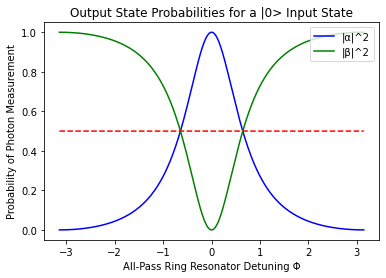

In [9]:
plt.plot(theta_ap, P_a_c, "-b", label="|\u03B1|^2")
# plt.plot(theta_ap, approx(theta_ap), '-g')
plt.plot(theta_ap, P_a_l, "-g", label="|\u03B2|^2")
plt.plot(theta_ap, dashedLine, 'r--')
plt.legend(loc="upper right")
plt.title("Output State Probabilities for a |0> Input State")
plt.xlabel("All-Pass Ring Resonator Detuning \u03A6")
plt.ylabel("Probability of Photon Measurement")

# plt.figure(2)
# plt.plot(theta_ap, phase_P_a_c, "-y")
plt.show()

In [10]:
U_f = np.array([single_RISQ_CALC(th, theta_t, 0, eta_stacked, tau_stacked, tau_ap) for th in theta_ap])
P_a_c = np.abs( ( U_f[:,0,0] )**2 )
P_a_l = np.abs( ( U_f[:,1,0] )**2 )

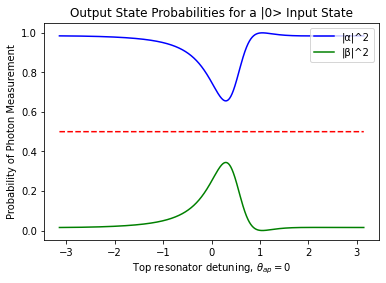

In [11]:
plt.plot(theta_ap, P_a_c, "-b", label="|\u03B1|^2")
# plt.plot(theta_ap, approx(theta_ap), '-g')
plt.plot(theta_ap, P_a_l, "-g", label="|\u03B2|^2")
plt.plot(theta_ap, dashedLine, 'r--')
plt.legend(loc="upper right")
plt.title("Output State Probabilities for a |0> Input State")
plt.xlabel(r'Top resonator detuning, $\theta_{ap} = 0$')
plt.ylabel("Probability of Photon Measurement")

# plt.figure(2)
# plt.plot(theta_ap, phase_P_a_c, "-y")
plt.show()

### Ask for derivative w.r.t. thetas

Since we just want a function of thetas, let's wrap the function with all the arguments into one with just thetas : 

In [12]:
def test_grad(theta_b, theta_t, theta_single):
    # These others ones will be fixed
    tau_stacked = 1/2
    eta_stacked = 1/2
    tau_ap = 1/2
    return single_RISQ_CALC(theta_b, theta_t, theta_single, eta_stacked, tau_stacked, tau_ap)

Because the output is a matrix, a gradient is innapropriate (not scalar). We will use vector-Jacobian product for the reverse-mode derivative instead (since the number of inputs and outputs is relatively small, we could also do the full Jacobian). See https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf

In [13]:
from autograd.test_util import check_vjp
from autograd.core import make_vjp, make_jvp, vspace
from autograd.wrap_util import unary_to_nary

In [14]:
make_vjp_nary = unary_to_nary(make_vjp)
vjp_output = make_vjp_nary(test_grad)(0., 0., 0.)

In [15]:
vjp_output

(<function autograd.core.make_vjp.<locals>.vjp(g)>,
 array([[1.+0.00000000e+00j, 0.+0.00000000e+00j],
        [0.+1.11022302e-16j, 1.+0.00000000e+00j]]))

It runs and returns as expected :

* The vjp function at [0], can be evaluated by adding the adjoints (g), where g has the shape of the outputs (here, 2x2 matrix). An adjoint is a derivative of the outputs w.r.t. to a scalar loss at the end of the computation.
* The result of the forward evaluation at [1]. Here, it was evaluated for `(theta_b, theta_t, theta_single) = (0., 0., 0.)` as per `make_vjp_nary(test_grad)` call.

OK, let's compare this "analytical" result to numerical differentiation with a small step "epsilon" :

In [16]:
# Need to adapt autograd source code

TOL  = 1e-6
RTOL = 1e-6
def scalar_close(a, b):
    return abs(a - b) < TOL or  abs(a - b) / abs(a + b) < RTOL

EPS  = 1E-6
def make_numerical_jvp(f, x):
    y = f(x)
    x_vs, y_vs = vspace(x), vspace(y)
    def jvp(v):
        # (f(x + v*eps/2) - f(x - v*eps/2)) / eps
        f_x_plus  = f(x_vs.add(x, x_vs.scalar_mul(v,  EPS/2)))
        f_x_minus = f(x_vs.add(x, x_vs.scalar_mul(v, -EPS/2)))
        neg_f_x_minus = y_vs.scalar_mul(f_x_minus, -1.0)
        return y_vs.scalar_mul(y_vs.add(f_x_plus, neg_f_x_minus), 1.0 / EPS)
    return jvp

@unary_to_nary
def check_vjp(f, x):
    vjp, y = make_vjp(f, x)
    jvp = make_numerical_jvp(f, x)
    x_vs, y_vs = vspace(x), vspace(y)
    x_v, y_v = x_vs.randn(), y_vs.randn()
    
    # Change from base code : our vjp is a list due to multiple inputs. We are only interested in Vbar, the first element :
    vjp_y = x_vs.covector(vjp(y_vs.covector(y_v)))
    assert vspace(vjp_y) == x_vs
    vjv_exact   = x_vs.inner_prod(x_v, vjp_y)
    vjv_numeric = y_vs.inner_prod(y_v, jvp(x_v))
    print('vjv_exact = ', vjv_exact, '\\ vjv_numeric = ', vjv_numeric)
    assert scalar_close(vjv_numeric, vjv_exact), \
        ("Derivative (VJP) check of {} failed with arg {}:\n"
         "analytic: {}\nnumeric:  {}".format(
            get_name(f), x, vjv_exact, vjv_numeric))

In [17]:
check_vjp(test_grad, 0)(0., 0., 0.)

vjv_exact =  -0.19314933850094165 \ vjv_numeric =  -0.19314933850095706


Here, $x$ is the argument we are differentiating against (`theta_b, theta_t, theta_single`) = `(0, 1, 2)`.

It did not raise an error, and so for this set of inputs at least the derivatives are correct (for the 0'th input `theta_b`, $\epsilon = 10^{-6}$, and for absolute tolerance $10^{-6}$ and relative tolerance $10^{-6}$).

Let's try at other input values : 

In [18]:
check_vjp(test_grad, 1)(np.pi/2, 0., 0.)

vjv_exact =  -3.0296129363846633 \ vjv_numeric =  -3.0296129369616764


In [19]:
check_vjp(test_grad, 2)(np.pi/2, 0., np.pi)

vjv_exact =  -0.4847424783506313 \ vjv_numeric =  -0.4847424781768249


In [20]:
check_vjp(test_grad, 0)(0.01, np.pi/3, 1.)

vjv_exact =  -2.120665932463565 \ vjv_numeric =  -2.1206659333601077


Should be OK?